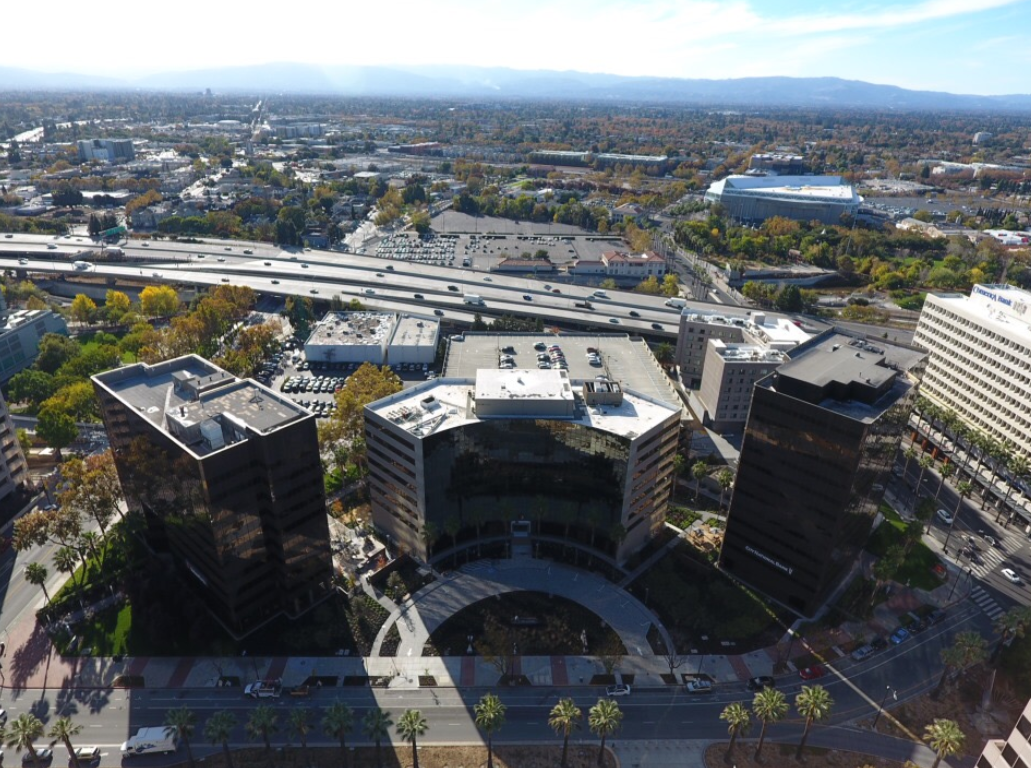

# My Capstone Project:
## Surrounding Business and Competitive analysis research for New Restaurant Location 

## 1. Import all libraries and modules required for project.

In [1]:
# Import all our required libraries.

# IMPORTANT: 
# Specific module install commands (prefaced by '#') are required by this project, i.e., for folium and geopy.
# To avoid repeat installs, which can be slow, comment these out after confirming operational success
# to install/upgrade to correct version.|

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
    
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library and plugins
from folium import plugins 

print('Libraries imported.')

Libraries imported.


#### Set up HTML Styles for tables

## 1.1 Data gather, wrangle, clean, aggregate, and queries 

Neighborhood data based on Postal Codes

Initial postal code data was pulled from dated postal service data found on usps site then stored to csv.
#Postal data for our regions was not complete nor completely accurate. 

A csv document was created with the required corrections. Discovered https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/ this week which compared and matched to our data.


#### Exclude P.O. Boxes from our zipcode set as they are unreliable markers for neighborhoods.

In [2]:
# San Jose list of P.O. Boxes as determined by cityname lookup on 
# https://california.hometownlocator.com/zip-codes/zipcodes,city,san%20jose.cfm
# Saved to csv for ongoing postal code review and changes seen with dated information.
df = pd.read_csv("neigh_data.csv")

# If zip is in P.O. Box list, then zipcode is removed from dataframe
PObox = ['95002', '95103', '95106', '95108', '95109', '95115', '95150', '95151', '95152', '95153', '95154', '95155', '95156', '95157', '95158', '95159', '95160', '95161', '95164', '95170', '95172', '95173']
df = df[~df['Zip'].isin(PObox)] 

print("New dataframe dimension after P.O. box cleaning:",df.shape,'[rows x cols]')
df.head(5)

New dataframe dimension after P.O. box cleaning: (70, 8) [rows x cols]


Zip   Latitude   Longitude Neighborhoods     Postal Address       City  \
0  95101  37.189396 -121.705327         Lundy     1750 Lundy Ave   San Jose   
1  95110  37.335545 -121.898770         Alma       1445 Monterey   San Jose   
2  95111  37.284042 -121.826640   Seven Trees        80 Lewis Rd   San Jose   
3  95112  37.348541 -121.886270    Japan Town      N. 5th Street  San  Jose   
4  95113  37.333941 -121.891540    James Park  105 N. 1st Street   San Jose   

  State               geopoint  
0    CA  37.189396,-121.705327  
1    CA   37.335545,-121.89877  
2    CA   37.284042,-121.82664  
3    CA   37.348541,-121.88627  
4    CA   37.333941,-121.89154

In [3]:
# Convert Zip code data type to object type from int as required for various upcoming steps
df.Zip = df.Zip.astype(dtype = str, errors='ignore') 
df.dtypes

Zip                object
Latitude          float64
Longitude         float64
Neighborhoods      object
Postal Address     object
City               object
State              object
geopoint           object
dtype: object

#### Zips shows as object.. We're ready for inital map..

### 1.2 Choropleth Rendered Map of Neighborhood marking within our Exploration Scope

- This map shows the postal code areas we'll be focusing some of our initial queries against.

- Map is initialized with focus centered and zoom set to San Jose - Southbay portions of Santa Clara County

- Note: tapping margin at left of map frame will take mapview out of the smaller notebook frame so you can then scroll within our larger view


In [4]:
#Geojson data reference info: https://datasf.org/opendata/

with open('Bay-Area-Counties.geojson') as f: #
    SBaySFArea = json.load(f) #

latitude = 37.3352849
longitude = -121.8917664

SBaySFAreaMap = folium.Map(location=[latitude,longitude], tiles='Stamen Toner', zoom_start=9) #

# Add the shape of South SF Bay Area to the map
folium.GeoJson(SBaySFArea).add_to(SBaySFAreaMap)

# Load the shape of the zone (US states)
# Information on Geojson data: https://github.com/python-visualization/folium/tree/master/examples/data
 
# Initialize the map:
#for each row dataset, I plot the corresponding latitude and longitude on the map
for i,row in df.iterrows():
    folium.CircleMarker((row.Latitude,row.Longitude), 
                        radius=3, weight=2, color='red', fill_color='red', fill_opacity=.5
                       ).add_to(SBaySFAreaMap)

#save the map as an html    
SBaySFAreaMap.save('SSFBayZipPlotMap.html')
SBaySFAreaMap

### 1.3 More cleaning

In [5]:
df.head(3)  # Our full neighborhood list is here. 
#Increase head() size from 3 rows to see full data

Zip   Latitude   Longitude Neighborhoods  Postal Address      City State  \
0  95101  37.189396 -121.705327         Lundy  1750 Lundy Ave  San Jose    CA   
1  95110  37.335545 -121.898770         Alma    1445 Monterey  San Jose    CA   
2  95111  37.284042 -121.826640   Seven Trees     80 Lewis Rd  San Jose    CA   

                geopoint  
0  37.189396,-121.705327  
1   37.335545,-121.89877  
2   37.284042,-121.82664

In [6]:
# We remove geopt column from our dataframe since we already have
# it combined. The errors=ignore option prevents 'geopt not found' 
# errors if function ran previously to complete the removal. 

df = df.drop('geopoint', 1, errors='ignore') 
print("New dataframe dimension after P.O. box cleaning:",df.shape,'[rows x cols]')
df.head(5)

New dataframe dimension after P.O. box cleaning: (70, 7) [rows x cols]


Zip   Latitude   Longitude Neighborhoods     Postal Address       City  \
0  95101  37.189396 -121.705327         Lundy     1750 Lundy Ave   San Jose   
1  95110  37.335545 -121.898770         Alma       1445 Monterey   San Jose   
2  95111  37.284042 -121.826640   Seven Trees        80 Lewis Rd   San Jose   
3  95112  37.348541 -121.886270    Japan Town      N. 5th Street  San  Jose   
4  95113  37.333941 -121.891540    James Park  105 N. 1st Street   San Jose   

  State  
0    CA  
1    CA  
2    CA  
3    CA  
4    CA

### Neighborhood Dataframe is ready...

### 2. Let's set up Geocoding and Folium Maps

In [7]:
from geopy.geocoders import Nominatim
address = '302 S. Market St, San Jose, CA'
geolocator = Nominatim(user_agent="foursquare user")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of San Jose, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of San Jose, CA are 37.3352849, -121.8917664.


#### San Jose mean latitude and longitude is calculated using all our Postal Location  data for San Jose and surrounding area.

For the search query and centering the map, I calculate mean latitude and longitude columns using  respective geo data columns we create in our neighborhood datasets.

An alternative method can also be used by plugging in San Jose cityname (only) in above 'address' param setting where Nominatim geolocation then performs a translation of physical address to geo coordinate address.

In [8]:
sj_meanlat = df.Latitude.mean()
sj_meanlong = df.Longitude.mean()
print(sj_meanlat,",",sj_meanlong)

37.30093621714286 , -121.8964906042857


#### Next we create map of South San Jose using latitude and longitude values and add markers to map and start exploring visuals.

In [9]:
df.dtypes

Zip                object
Latitude          float64
Longitude         float64
Neighborhoods      object
Postal Address     object
City               object
State              object
dtype: object

### 2.1 Folium Circle Marker

### This is another folium map showing circlemarkers to depict neighborhood data.

In [74]:
map_southsj = folium.Map(location=[37.30093621714286, -121.8964906042857], zoom_start=10)

# add markers to map
for lat, lng, city, neighborhoods in zip(df['Latitude'], df['Longitude'], df['City'], df['Neighborhoods']):
    label = '{}, {}'.format(neighborhoods, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_southsj)  
    
map_southsj


In [75]:
df['Neighborhoods'].count()

70

In [76]:
df.head(3)

Zip   Latitude   Longitude Neighborhoods  Postal Address      City State
0  95101  37.189396 -121.705327         Lundy  1750 Lundy Ave  San Jose    CA
1  95110  37.335545 -121.898770         Alma    1445 Monterey  San Jose    CA
2  95111  37.284042 -121.826640   Seven Trees     80 Lewis Rd  San Jose    CA

# 3. San Jose and Southbay Top Breakfast Restaurants
For any new restaurant, knowing who your competition is, where they're located, and the specific areas and data that associates with higher venue traffic (which translates to higher revenue) is key to planning restaurant location and to explore and understand the "Why? questions". All are important factors for effecting for business decisions. Here I provide various data for client exploration.

The list of restaurants were referenced here: 
https://www.sanjose.org/restaurants?field_city_value=san%20jose#restaurants-listing 

Once downloaded, these were catalogued to csv for updating then reloaded here. 

Many disparate data source pieces were researched and pulled together for this project and will likely merge and evolve and find their place as a reliable data source for restaurant accuracy within the Bay Area.

#### Load basic data sample of our Top Breakfast location spots


In [77]:
# Load basic data sample of our Top Breakfast location spots
# https://www.sanjose.org/restaurants?field_city_value=san%20jose#restaurants-listing
sj_tb = pd.read_csv("./sj-org-top-area-restaurants.csv")
sj_tb.count()

Top Breakfast Restaurant    26
Address                     26
City                        26
State                       26
Zip                         26
SanJose.org Best Rate       26
dtype: int64

#### Looks good. To run this through geocoder, we need to combine address data into one string. Since I also need the address information for Map marker popups later, I create a FullAddress column here less the zip code which we need a column on its own.

In [78]:
#Convert Zip code data type to object type from int as required for next step
sj_tb.Zip = sj_tb.Zip.astype(str) 

#Combine address data in stb cols
sj_tb['FullAddress'] = sj_tb['Address']+', '+sj_tb['City']+', '+sj_tb['State']#+' '+stb['Zip']

In [79]:
sj_tb.head(5) #

Top Breakfast Restaurant                    Address      City  \
0                 Il Fornaio    302 South Market Street  San Jose   
1             La Lune Sucree   116 Paseo de San Antonio  San Jose   
2               The Fountain    170 South Market Street  San Jose   
3                   488 Cafe      488 Almaden Boulevard  San Jose   
4  Bill's Cafe - Willow Glen         1115 Willow Street  San Jose   

         State    Zip  SanJose.org Best Rate  \
0   California  95113                      1   
1   California  95112                      1   
2   California  95113                      1   
3   California  95113                      1   
4   California  95125                      1   

                                        FullAddress  
0    302 South Market Street, San Jose,  California  
1   116 Paseo de San Antonio, San Jose,  California  
2    170 South Market Street, San Jose,  California  
3      488 Almaden Boulevard, San Jose,  California  
4         1115 Willow Street, San Jose,  California

# 4. Population Density by Zip Code
- This dataset is also very key for our report. The goal and thought process here is for data inference so we can deduce properties of underlying distribution and probability. We can use California population data on zip codes to develop a better understanding of restaurant to population ratios, current and potential venue growth traffic, and geographical opportunities for property placement based on this notion.


In [80]:
import csv

url="https://www.california-demographics.com/zip_codes_by_population"
popbyzip = pd.read_html(url)
popbyzip=popbyzip[0]

#popbyzip.to_csv("popbyzip.csv")
popbyzip=pd.read_csv("popbyzip.csv", index_col=[0])
popbyzip.rename(columns={'Zip Code':'Zip'}, inplace=True)
print('California has',popbyzip.Zip.shape,'zipcodes')

California has (1674,) zipcodes


- Our zipcode use will be a small fraction of this zipcode scope. We will merge this dataframe in a upcoming section with our sanjose_venue merge data. 

- The goal then will be to group and sort on our venue cluster dataset to sort and review the population data.

- That step will provide for improved analysis and correlation.

#### Table above looks good. Let's add our geodata to these cells next.

- The geodecode section below doesn't need to fire every time we load this notebook cell.
- Therefore it can be commented out to decrease Nominator use while we're in dev and test phase. 
- Avoids hitting max limits everytime we refresh notebook cells. To offload, we simply copy our geolocation data and store geocode to sj_tb.to_csv("topRestaurants.csv") using methods below.

#### Create a sj_tb (san jose top breakfast) dataframe

In [81]:
sj_tb["loc"]= sj_tb["FullAddress"].apply(geolocator.geocode)  # Comment out when there is no need to run
sj_tb["point"]= sj_tb["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
sj_tb[['lat', 'lon', 'altitude']] = pd.DataFrame(sj_tb['point'].to_list(), index=sj_tb.index)

This method creates the following:
- Location column populated with geolocation decoded information from the physical address.
- Second command creates a geopoint, combined from seperate lat and long data. 
- It will split point column into latitude, longitude and altitude columns… concatenate address columns into one
- Last command wraps things up to list and index.
- Nice 3-line piece of code that originated on stackoverflow or elsewhere in bits and pieces I cobbled together. It's been waiting for a home and has found one. 

#### We now have our new geodata adds in our dataframe, showing loc, point, and lat information.

In [82]:
sj_tb.head(2)

Top Breakfast Restaurant                    Address      City        State  \
0               Il Fornaio    302 South Market Street  San Jose   California   
1           La Lune Sucree   116 Paseo de San Antonio  San Jose   California   

     Zip  SanJose.org Best Rate  \
0  95113                      1   
1  95112                      1   

                                        FullAddress  \
0    302 South Market Street, San Jose,  California   
1   116 Paseo de San Antonio, San Jose,  California   

                                                 loc  \
0  (The Westin San Jose, 302, South Market Street...   
1  (La Lune Sucree, 116, Paseo de San Antonio, Pa...   

                                    point        lat         lon  altitude  
0  (37.3311418, -121.88725910052878, 0.0)  37.331142 -121.887259       0.0  
1         (37.3336296, -121.8850898, 0.0)  37.333630 -121.885090       0.0

#### Next, we derive a central reference point for all the top restaurants within scope of our top restaurant data set which folium will use to center map and review our dataset for required adjustments.

In [83]:
sj_tb2 = sj_tb #sj_tb is for San Jose Top Breakfast for nominatum use. 
sj_tb2_mean_lat = sj_tb2.lat.mean()
sj_tb2_mean_lon = sj_tb2.lon.mean()
print("Our Map Centering Geocoordinates: ",sj_tb2_mean_lat, sj_tb2_mean_lon)

Our Map Centering Geocoordinates:  37.313116549688125 -121.91558015919185


In [84]:
sj_tb2.dtypes #This fits are model, but we won't need altitude data.

Top Breakfast Restaurant     object
Address                      object
City                         object
State                        object
Zip                          object
SanJose.org Best Rate         int64
FullAddress                  object
loc                          object
point                        object
lat                         float64
lon                         float64
altitude                    float64
dtype: object

Removing altitude, and ignoring any errors if already removed.

In [85]:
sj_tb2 = sj_tb2.drop('altitude', 1, errors='ignore')

In [86]:
sj_tb2.isnull().sum() # Alternative confirmation

Top Breakfast Restaurant    0
Address                     0
City                        0
State                       0
Zip                         0
SanJose.org Best Rate       0
FullAddress                 0
loc                         0
point                       0
lat                         0
lon                         0
dtype: int64

## 3.1 Folium Marker Cluster Map, Folium CircleMarker with popup labels

#### Here we overlay top breakfast locations for San Jose and surrounding areas
#### We create an overall folium map, combined using two child maps.  The goal here is to provide a mechanism for client to see where many of the top restaurants are.

- Child map 1: Shown Neighborhood location markers are top breakfast locations centered on mean latitude and longitude geos across all neighborhoods.  The larger hula shaped circle markers, represent postal office locations within each zip code. Postal codes support a popular method for identifying neighborhood/suburb locations.  There are more complex methods used to more accurately identify entire zip code regions and suburbs using polygons, postal route data, or county borders information. For now, postal method works well for our goals.  I do plan to add postalzones to the maps.

- Child map2: These pin markers with pop-ups are top breakfast restaurants rated by SanJose.org where addresses are geocoded with precision. This helps for visual examination of cross-traffic data for our  client who requires  competitive whereabout information data. 

In [87]:
map_southsj = folium.Map(location=[sj_tb2_mean_lat, sj_tb2_mean_lon], zoom_start=10)


# instantiate a mark cluster object for the incidents in the dataframe
map_southsj2 = plugins.MarkerCluster().add_to(map_southsj)

# Add our neighborhood data to our map
for lat, lng, city, neighborhoods in zip(df['Latitude'], df['Longitude'], 
                                           df['City'], df['Neighborhoods']):
    label = '{}, {}'.format(neighborhoods, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#ffeeee',
        fill_opacity=0.7,
        parse_html=False).add_to(map_southsj)
map_southsj

# Create a new map of top restaurants in San Jose and Southbay on mean latitude and longitude
# Do we need to recenter map? Advantages? Disadvantages?

map_southsj3 = folium.Map(location=[sj_tb2_mean_lat, sj_tb2_mean_lon], zoom_start=10)
# add markers to map
for lat, lng, loc, z, top_b_loc in zip(sj_tb2['lat'], sj_tb2['lon'], sj_tb2['loc'], 
                            sj_tb2['Zip'],sj_tb2['Top Breakfast Restaurant']):
    label = '{}: {}, {}'.format(top_b_loc, loc, z)
    label = folium.Popup(label, parse_html=True)
    
    folium.Marker(
        [lat, lng],
        popup=label).add_to(map_southsj)
    
map_southsj 
  

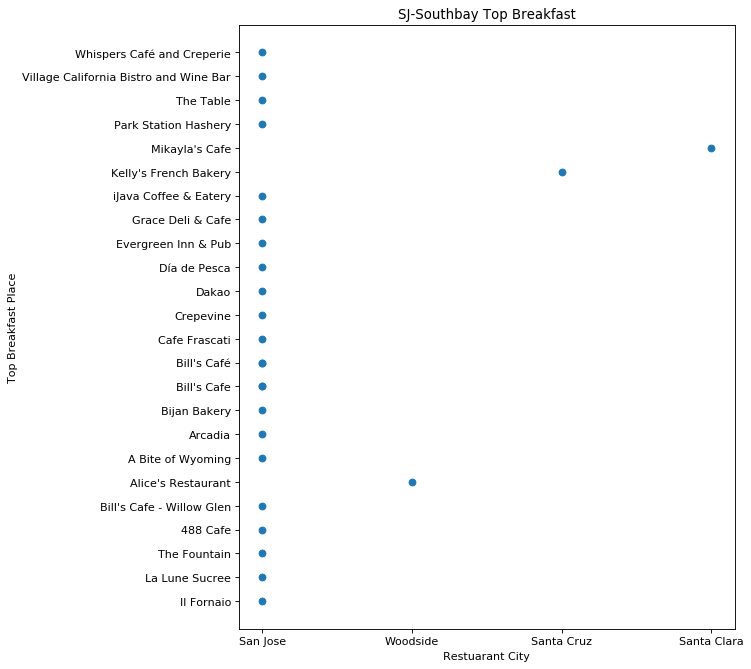

<Figure size 1600x560 with 0 Axes>

In [88]:
import matplotlib.pyplot as plt
sj_tb2

# create a figure and axis
fig, ax = plt.subplots()

# scatter the city data length against the zip data width
ax.scatter(sj_tb2['City'], sj_tb2['Top Breakfast Restaurant'])

# set a title and labels
ax.set_title('SJ-Southbay Top Breakfast')
ax.set_xlabel('Restuarant City')
ax.set_ylabel('Top Breakfast Place')

fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(20)
plt.rcParams['figure.figsize'] = [8, 10]
plt.rcParams['figure.dpi'] = 80 # 200 e.g. is really fine, but slower

In [89]:
print("The data frame dimensions are", df.shape, ", #rows x #columns.")

The data frame dimensions are (70, 7) , #rows x #columns.


In [90]:
print("Data types for all data features is as follows:\n",df.dtypes)

Data types for all data features is as follows:
 Zip                object
Latitude          float64
Longitude         float64
Neighborhoods      object
Postal Address     object
City               object
State              object
dtype: object


# FOURSQUARE API

#### This next section is where we configure our Foursquare API requests and communications.

- A Foursquare account is required. Free Foursquare developer accounts are available but only for low volume and low feature usage.
- API credentials should not be shared. 

Suggested approach:
- Make a copy of your notebook.
- Run kernel update on all the cells of the copy Notebook
- Delete the API credential cells from your copy Notebook
- Run nbconvert from command line to convert file then post on github. Google nbconvert command options as there are several.



In [167]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


## 1. Search for a specific venue category
> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

#### Get Geolocation data for postal codes

- Let's define the corresponding URL for our Venue Search to find Restaurants in specific Zipcode locales.

In [92]:
# Enter Search Address, Query, Radius (in meters), and max return limit (100 is max)
QUERY = 'Restaurants'
SEARCH_ADDRESS = '302 S. Market St, San Jose, CA' #ENTER
RADIUS = '2000'
LIMIT = '100'
VERSION = '20180604'
print(QUERY + ' .... OK!')

Restaurants .... OK!


In [93]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="foursquare user")
location = geolocator.geocode(SEARCH_ADDRESS)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Jose, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Jose, CA are 37.3352849, -121.8917664.


In [94]:
# Here we build our search query using the user-supplied and geocode API supplied data.
import json, requests

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, QUERY, RADIUS, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=SOJZXT4G2WIN110GL40AM2ULYZHXBSRTNN5F3M22IHPDJZ2V&client_secret=QDFVARGC2XAYU1VV3FNGYNTGMGCREWUWP4FXEBXPL5OVTXCG&ll=37.3352849,-121.8917664&v=20180604&query=Restaurants&radius=2000&limit=100'

#### Send the GET Request and examine list of venues found

In [95]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f4092fb474df229565d925b'},
 'response': {'venues': [{'id': '5e14132aea67c90007e98184',
    'name': 'Subway',
    'location': {'address': 'Union Square,211 South 9th St',
     'lat': 37.336361,
     'lng': -121.881287,
     'labeledLatLngs': [{'label': 'display',
       'lat': 37.336361,
       'lng': -121.881287}],
     'distance': 935,
     'postalCode': '95112',
     'cc': 'US',
     'city': 'San Jose',
     'state': 'CA',
     'country': 'United States',
     'formattedAddress': ['Union Square,211 South 9th St',
      'San Jose, CA 95112',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1c5941735',
      'name': 'Sandwich Place',
      'pluralName': 'Sandwich Places',
      'shortName': 'Sandwiches',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1598068078',
    'hasPerk': False},
   {'id': '4b69e859f964a5206dbb2be3',
    'n

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [96]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.name.head()

C:\Users\ericl\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


0                          Subway
1      Keystone Restaurant Supply
2    SJ Omogari Korean Restaurant
Name: name, dtype: object

#### Define information of interest and filter dataframe

In [97]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

name         categories  \
0                        Subway     Sandwich Place   
1    Keystone Restaurant Supply         Restaurant   
2  SJ Omogari Korean Restaurant  Korean Restaurant   

                         address        lat         lng  \
0  Union Square,211 South 9th St  37.336361 -121.881287   
1            491 W San Carlos St  37.326062 -121.898147   
2                 154 Jackson St  37.348493 -121.895269   

                                      labeledLatLngs  distance postalCode  cc  \
0  [{'label': 'display', 'lat': 37.336361, 'lng':...       935      95112  US   
1  [{'label': 'display', 'lat': 37.32606214341275...      1171      95110  US   
2  [{'label': 'display', 'lat': 37.34849301769265...      1502      95112  US   

       city state        country  \
0  San Jose    CA  United States   
1  San Jose    CA  United States   
2  San Jose    CA  United States   

                                    formattedAddress crossStreet  \
0  [Union Square,211 South 9th St, San Jose, CA 9...         NaN   
1  [491 W San Carlos St (Josefa St), San Jose, CA...   Josefa St   
2  [154 Jackson St, San Jose, CA 95112, United St...         NaN   

                         id  
0  5e14132aea67c90007e98184  
1  4b69e859f964a5206dbb2be3  
2  4a3bec21f964a520eaa01fe3

#### Let's visualize the Italian restaurants that are nearby

In [98]:
dataframe_filtered.name

0                          Subway
1      Keystone Restaurant Supply
2    SJ Omogari Korean Restaurant
Name: name, dtype: object

In [99]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

## Explore a specific venue

### A. Let's explore the closest Italian restaurant -- _ID OF VENUE_

In [101]:
venue_id = '5e14132aea67c90007e98184' # ID of Venue

> `https://api.foursquare.com/v2/venues/`**VENUE_ID**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&v=`**VERSION**

In [102]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

KeyError: 'venue'

In [103]:
### B. Get the venue's overall rating

In [104]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


That is not a very good rating. Let's check the rating of the second closest Italian restaurant.

In [106]:
venue_id = '5e14132aea67c90007e98184' # 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


Since this restaurant has no ratings, let's check the third restaurant.

In [108]:
venue_id = '3fd66200f964a520f4e41ee3' # ID of Ecco
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.3


In [72]:
### C. Get the number of tips

### D. Get the venue's tips
> `https://api.foursquare.com/v2/venues/`**VENUE_ID**`/tips?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&v=`**VERSION**`&limit=`**LIMIT**

### D. Get the venue's tips

#### Create URL and send GET request. Make sure to set limit to get all tips

#### Create URL and send GET request. Make sure to set limit to get all tips

In [110]:
## Ecco Tips
limit = 15 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f409579c7db23607204cce6'},
 'response': {'tips': {'count': 19,
   'items': [{'id': '5ab1cb46c9a517174651d3fe',
     'createdAt': 1521601350,
     'text': 'A+ Italian food! Trust me on this: my mom’s side of the family is 100% Italian. I was born and bred to know good pasta when I see it, and Ecco is one of my all-time NYC favorites',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/5ab1cb46c9a517174651d3fe',
     'lang': 'en',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'agreeCount': 5,
     'disagreeCount': 0,
     'lastVoteText': 'Upvoted 5 days ago',
     'lastUpvoteTimestamp': 1597593442,
     'todo': {'count': 0},
     'user': {'id': '484542633',
      'firstName': 'Nick',
      'lastName': 'E',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/484542633_unymNUmw_FdPs3GjXHujmHcYnN4hf8kEPADlOZuIrdcdm97VX3tFqL7fFNMNA_8Gl9NlU1GYg.jpg'}},
     'authorInteractionType': '

#### Get tips and list of associated features

In [111]:
tips = results['response']['tips']['items']

tip = results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'lang', 'likes', 'logView', 'agreeCount', 'disagreeCount', 'lastVoteText', 'lastUpvoteTimestamp', 'todo', 'user', 'authorInteractionType'])

#### Format column width and display all tips

In [112]:
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips) # json normalize tips

# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.gender', 'user.id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
tips_filtered

C:\Users\ericl\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.
C:\Users\ericl\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

Now remember that because we are using a personal developer account, then we can access only 2 of the restaurant's tips, instead of all 15 tips.

## 3. Search a Foursquare User


### Define URL, send GET request and display features associated with user

In [114]:
user_id = '484542633' # user ID with most agree counts and complete profile

url = 'https://api.foursquare.com/v2/users/{}?client_id={}&client_secret={}&v={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION) # define URL

# send GET request
results = requests.get(url).json()
user_data = results['response']['user']

# display features associated with user
user_data.keys()

KeyError: 'user'

In [115]:
print('First Name: ' + user_data['firstName'])
print('Last Name: ' + user_data['lastName'])
print('Home City: ' + user_data['homeCity'])

NameError: name 'user_data' is not defined

#### How many tips has this user submitted?

In [117]:
user_data['tips']

NameError: name 'user_data' is not defined

Wow! So it turns out that Nick is a very active Foursquare user, with more than 250 tips.

### Get User's tips

In [118]:
# define tips URL
url = 'https://api.foursquare.com/v2/users/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

# send GET request and get user's tips
results = requests.get(url).json()
tips = results['response']['tips']['items']

# format column width
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips)

# filter columns
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display user's tips
tips_filtered

C:\Users\ericl\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':
C:\Users\ericl\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()


text  \
0   They serve coffee!!!!!!                                                                                                                                                                           
1   Quick, cheap lunch that tastes good! Way shorter line than Chipotle, too.                                                                                                                         
2   You’re not a real New Yorker until you’ve shame-ordered Insomnia Cookies for delivery at 3am                                                                                                      
3   Good for you yet still tasty! Clean green protein is my go-to after I hit the gym 💪                                                                                                               
4   Burger game strong 💪                                                                                                                                                                              
5   Great burgers & fries! Also, this place is exactly what it’s like when you go to a bar in the Southwest. Source: I’m from Arizona.                                                                
6   Açaí bowl + peanut butter + whey protein = 💪💪💪                                                                                                                                                    
7   Highly underrated and way less crowded than Central Park!                                                                                                                                         
8   Way easier to navigate than the Met proper, plus the Met Breuer focuses on modern art. If I only have a limited amount of time to spend in a museum, I would rather go here than anywhere else!   
9   Get the açaí bowl with peanut butter after your work out and thank me later 👌                                                                                                                     
10  When you want a burger, this should be the first thing that comes to mind. A+!                                                                                                                    
11  Way less crowded than Central Park! People who live in the neighborhood rave about Carl Schurz Park.                                                                                              
12  The best Mexican food in the Murray Hill / Kips Bay area!                                                                                                                                         
13  Best coffee shop in the neighborhood!                                                                                                                                                             
14  When there’s nice weather, the rooftop at Tonic East is the best place to watch the game. Perfect for March Madness & NBA finals!                                                                 

    agreeCount  disagreeCount                        id  
0   1           0              5accc98c0313204c9d7ec157  
1   2           0              5acbec70a0215b732e264fe8  
2   1           0              5acbbd4eb1538e45373b07f5  
3   2           0              5acbbcda01235808d5d6dc75  
4   1           0              5ab575fb6bdee65f759da8c1  
5   2           0              5ab5575d73fe2516ad8f363b  
6   1           0              5ab42db53c858d64af2688a4  
7   3           0              5ab42c396f706a29f53ad1a8  
8   6           0              5ab42b987dc9e17930e5ff5b  
9   1           0              5ab42aca2a7ab6333652b266  
10  1           0              5ab42a28da5e5617d18e3a6a  
11  3           0              5ab429db1ffe971b060083f5  
12  1           0              5ab3f53f8496ca57542d5549  
13  1           0              5ab3f428da5e5617d17d1475  
14  2           0              5ab3f3fedd70c572de886c9d

#### Let's get the venue for the tip with the greatest number of agree counts

In [120]:
tip_id = '5ab5575d73fe2516ad8f363b' # tip id

# define URL
url = 'http://api.foursquare.com/v2/tips/{}?client_id={}&client_secret={}&v={}'.format(tip_id, CLIENT_ID, CLIENT_SECRET, VERSION)

# send GET Request and examine results
result = requests.get(url).json()
print(result['response']['tip']['venue']['name'])
print(result['response']['tip']['venue']['location'])

Cowgirl
{'address': '519 Hudson St', 'crossStreet': 'at W 10th St', 'lat': 40.73373338282062, 'lng': -74.0062998849649, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73373338282062, 'lng': -74.0062998849649}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['519 Hudson St (at W 10th St)', 'New York, NY 10014', 'United States']}


### Get User's friends

In [121]:
user_friends = json_normalize(user_data['friends']['groups'][0]['items'])
user_friends

NameError: name 'user_data' is not defined

Interesting. Despite being very active, it turns out that Nick does not have any friends on Foursquare. This might definitely change in the future.

In [122]:
### Retrieve the User's Profile Image

In [123]:
user_data

NameError: name 'user_data' is not defined

4. Explore a location

    https://api.foursquare.com/v2/venues/explore?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&limit=LIMIT



#### So, you just finished your gourmet dish at Ecco, and are just curious about the popular spots around the restaurant. In order to explore the area, let's start by getting the latitude and longitude values of Ecco Restaurant.

In [135]:
latitude = 37.336361
longitude = -121.881287

#### Define URL

In [136]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=SOJZXT4G2WIN110GL40AM2ULYZHXBSRTNN5F3M22IHPDJZ2V&client_secret=QDFVARGC2XAYU1VV3FNGYNTGMGCREWUWP4FXEBXPL5OVTXCG&ll=37.336361,-121.881287&v=20180604&radius=2000&limit=100'

#### Send GET request and examine results

In [137]:
import requests

In [140]:
results = requests.get(url).json()
'There are {} around downtown restaurants.'.format(len(results['response']['groups'][0]['items']))

'There are 100 around downtown restaurants.'

#### Get relevant part of JSON

In [141]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4b0c3661f964a520fd3823e3',
  'name': 'House of Bagels',
  'location': {'address': '505 E San Carlos St',
   'crossStreet': 'at 11th St',
   'lat': 37.33671807777529,
   'lng': -121.87639173760293,
   'labeledLatLngs': [{'label': 'display',
     'lat': 37.33671807777529,
     'lng': -121.87639173760293}],
   'distance': 435,
   'postalCode': '95112',
   'cc': 'US',
   'city': 'San Jose',
   'state': 'CA',
   'country': 'United States',
   'formattedAddress': ['505 E San Carlos St (at 11th St)',
    'San Jose, CA 95112',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d179941735',
    'name': 'Bagel Shop',
    'pluralName': 'Bagel Shops',
    'shortName': 'Bagels',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bagels_',
     'suffix': '.png'},
    'primary': True}],
  'delivery': {'id': '18291

#### Process JSON and convert it to a clean dataframe

In [142]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

C:\Users\ericl\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


name                     categories  \
0  House of Bagels                Bagel Shop                      
1  Yogurtland                     Frozen Yogurt Shop              
2  Philz Coffee                   Coffee Shop                     
3  Thai Chili Express             Thai Restaurant                 
4  Vegetarian House               Vegetarian / Vegan Restaurant   
5  ComedySportz                   Comedy Club                     
6  Lee's Sandwiches               Sandwich Place                  
7  Silicon Valley Capital Club    Restaurant                      
8  The Studio Climbing & Fitness  Climbing Gym                    
9  nox cookie bar                 Dessert Shop                    

                      address crossStreet        lat         lng  \
0  505 E San Carlos St         at 11th St  37.336718 -121.876392   
1  125 East San Carlos Street  NaN         37.333020 -121.884331   
2  118 Paseo de San Antonio    at 4th St   37.333725 -121.885038   
3  304 E Santa Clara St Ste D  7th Street  37.338900 -121.883778   
4  520 E Santa Clara St        at 12th St  37.341433 -121.879176   
5  288 S 2nd St                NaN         37.332438 -121.886028   
6  260 E Santa Clara St        at 6th St   37.338441 -121.884817   
7  50 W San Fernando St        NaN         37.333945 -121.889317   
8  396 E San Salvador St       NaN         37.330273 -121.886095   
9  151 S 2nd St, Suite 185     NaN         37.334070 -121.887332   

                                                                                                                             labeledLatLngs  \
0  [{'label': 'display', 'lat': 37.33671807777529, 'lng': -121.87639173760293}]                                                               
1  [{'label': 'display', 'lat': 37.33302, 'lng': -121.884331}, {'label': 'entrance', 'lat': 37.332969, 'lng': -121.884333}]                   
2  [{'label': 'display', 'lat': 37.33372540768604, 'lng': -121.88503757822234}]                                                               
3  [{'label': 'display', 'lat': 37.33890015900095, 'lng': -121.883778191927}]                                                                 
4  [{'label': 'display', 'lat': 37.341433051588915, 'lng': -121.87917600579642}]                                                              
5  [{'label': 'display', 'lat': 37.332438, 'lng': -121.8860278}]                                                                              
6  [{'label': 'display', 'lat': 37.33844082567248, 'lng': -121.8848174659776}, {'label': 'entrance', 'lat': 37.338485, 'lng': -121.884876}]   
7  [{'label': 'display', 'lat': 37.3339453, 'lng': -121.8893173}, {'label': 'entrance', 'lat': 37.334059, 'lng': -121.889434}]                
8  [{'label': 'display', 'lat': 37.33027302291874, 'lng': -121.88609474110798}]                                                               
9  [{'label': 'display', 'lat': 37.33407043155909, 'lng': -121.88733173601287}]                                                               

   distance postalCode  cc      city state        country  \
0  435       95112      US  San Jose  CA    United States   
1  459       95112      US  San Jose  CA    United States   
2  443       95112      US  San Jose  CA    United States   
3  358       95113      US  San Jose  CA    United States   
4  594       95112      US  San Jose  CA    United States   
5  605       95113      US  San Jose  CA    United States   
6  388       95113      US  San Jose  CA    United States   
7  759       95113      US  San Jose  CA    United States   
8  800       95112      US  San Jose  CA    United States   
9  592       95113      US  San Jose  CA    United States   

                                                               formattedAddress  \
0  [505 E San Carlos St (at 11th St), San Jose, CA 95112, United States]          
1  [125 East San Carlos Street, San Jose, CA 95112, United States]                
2  [118 Paseo de San Antonio (at 4th St), San 

#### Let's visualize these items on the map around our location

In [143]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


# add Ecco as a red circle mark
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

## 5. Explore Trending Venues
> `https://api.foursquare.com/v2/venues/`**trending**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**

#### Now, instead of simply exploring the area around Ecco, you are interested in knowing the venues that are trending at the time you are done with your lunch, meaning the places with the highest foot traffic. So let's do that and get the trending venues around Ecco.

In [144]:
# define URL
url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)

# send GET request and get trending venues
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f40969cbe0e0c62271dd180'},
 'response': {'venues': []}}

In [145]:
### Check if any venues are trending at this time

In [146]:
if len(results['response']['venues']) == 0:
    trending_venues_df = 'No trending venues are available at the moment!'
    
else:
    trending_venues = results['response']['venues']
    trending_venues_df = json_normalize(trending_venues)

    # filter columns
    columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
    trending_venues_df = trending_venues_df.loc[:, columns_filtered]

    # filter the category for each row
    trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)

In [147]:
# display trending venues
trending_venues_df

'No trending venues are available at the moment!'

Now, depending on when you run the above code, you might get different venues since the venues with the highest foot traffic are fetched live. 

### Visualize trending venues

In [150]:
if len(results['response']['venues']) == 0:
    venues_map = 'Cannot generate visual as no trending venues are available at the moment!'

else:
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


    # add Ecco as a red circle mark
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=10,
        popup='Ecco',
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_map)


    # add the trending venues as blue circle markers
    for lat, lng, label in zip(trending_venues_df['location.lat'], trending_venues_df['location.lng'], trending_venues_df['name']):
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            poup=label,
            fill=True,
            color='blue',
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(venues_map)

In [151]:
# display map
venues_map

'Cannot generate visual as no trending venues are available at the moment!'

# 2. Explore Neighborhood Venues in or Near Downtown San Jose, CA

#### We use Foursquare Explore feature to get the top 100 venues that are within a radius of 2000 meters of specified downtown spot.

#### We determine the geo center physical address of our dataset  by supplying the mean lat and long values to geolocator to process across our entire dataset of lat and long columns. It then provides us with the physical address we can enter for our search area.

In [152]:
meanlat=df.Latitude.mean()
meanlng=df.Longitude.mean()
coordinates = meanlat,meanlng
location = geolocator.reverse(coordinates)
location.raw

{'place_id': 243336007,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 8949989,
 'lat': '37.30100610560653',
 'lon': '-121.89648480633416',
 'display_name': '1121, Nevada Avenue, Willow Glen, San Jose, Santa Clara County, California, 95125, United States of America',
 'address': {'house_number': '1121',
  'road': 'Nevada Avenue',
  'suburb': 'Willow Glen',
  'city': 'San Jose',
  'county': 'Santa Clara County',
  'state': 'California',
  'postcode': '95125',
  'country': 'United States of America',
  'country_code': 'us'},
 'boundingbox': ['37.300956105607',
  '37.301056105607',
  '-121.89653480633',
  '-121.89643480633']}

In [153]:
#Our venue dataset center address
neighbor_dataset_center_address = "1121 Nevada Ave, San Jose, CA"

In [154]:
# create the API request URL
near = neighbor_dataset_center_address
radius = '2000'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, near, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=SOJZXT4G2WIN110GL40AM2ULYZHXBSRTNN5F3M22IHPDJZ2V&client_secret=QDFVARGC2XAYU1VV3FNGYNTGMGCREWUWP4FXEBXPL5OVTXCG&v=20180604&near=1121 Nevada Ave, San Jose, CA&radius=2000&limit=100'

#### Send our GET Request for data

In [155]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f40959a12fd07486948b61c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'geocode': {'what': '',
   'where': '1121 Nevada Ave, San Jose, CA',
   'center': {'lat': 37.30112, 'lng': -121.89625},
   'displayString': '1121 Nevada Ave',
   'cc': 'US'},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 121,
  'suggestedBounds': {'ne': {'lat': 37.32914180436336,
    'lng': -121.86141506200454},
   'sw': {'lat': 37.273117762152395, 'lng': -121.92534154536781}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4a85d37bf964a5205eff1fe3',
  

#### Get our category and venue category types

In [156]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [157]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

C:\Users\ericl\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


name                categories  \
0   Hicklebee's Bookstore                    Bookstore                  
1   Pizza My Heart                           Pizza Place                
2   Taiwan Restaurant                        Chinese Restaurant         
3   Baskin-Robbins                           Ice Cream Shop             
4   Bibo's NY Pizza                          Pizza Place                
5   20twenty cheese bar                      Wine Bar                   
6   Lift                                     Gym                        
7   Willow Glen Creamery                     Ice Cream Shop             
8   Mariette Premium Chocolates              Dessert Shop               
9   Aqui Cal-Mex                             Mexican Restaurant         
10  Starbucks                                Coffee Shop                
11  Siena Bistro                             Italian Restaurant         
12  Souvlaki Greek Skewers                   Greek Restaurant           
13  Bill's Cafe                              Breakfast Spot             
14  Cafe Gourmet                             Café                       
15  La Villa Delicatessen & Gourmet Shop     Deli / Bodega              
16  Braise Restaurant & Bar                  Restaurant                 
17  Powell's Sweet Shoppe                    Candy Store                
18  Main Street Burgers                      Burger Joint               
19  Jake's of Willow Glen                    Pizza Place                
20  The Table                                New American Restaurant    
21  Peet's Coffee & Tea                      Coffee Shop                
22  River Glen Park                          Playground                 
23  SusieCakes                               Cupcake Shop               
24  West Coast Cigars                        Smoke Shop                 
25  Willow Street Frank Bramhall Park        Playground                 
26  Los Gatos Creek Trail                    Trail                      
27  TOGO'S Sandwiches                        Sandwich Place             
28  Thai Spice                               Thai Restaurant            
29  Red Dot Fitness                          Gym                        
30  Dry Creek Grill                          American Restaurant        
31  Tomato Thyme                             Italian Restaurant         
32  Yum Yum Donuts                           Donut Shop                 
33  Fratello                                 Italian Restaurant         
34  Cafe San José                            Breakfast Spot             
35  Los Gatos Creek Trail                    Trail                      
36  Hapa's Brewing Company                   Brewery                    
37  Subway                                   Sandwich Place             
38  Starbucks                                Coffee Shop                
39  Gunther's Restaurant and Catering        German Restaurant          
40  Pho Wagon                                Vietnamese Restaurant      
41  Nothing Bundt Cakes                      Bakery                     
42  Tequilas Taqueria                        Mexican Restaurant         
43  Willow Glen Farmers' Market              Farmers Market             
44  San Jose Swim and Raquet Club            Gym                        
45  Starbucks                                Coffee Shop                
46  Dollar Tree                              Discount Store             
47  Amatos                                   Sandwich Place             
48  Sacred Heart Community Service           Office                     
49  Grab A Pita                              Mediterranean Restaurant   
50  Del Monte Dog Park                       Dog Run                    
51  Safeway                                  Grocery Store              
52  Arteaga's Food Center                    Grocery Store              
53  Curvy Girl Lingerie                      Lingerie Store             
54  Rite Aid            

# 3. Analyze Each Neighborhood

In [158]:
df.Neighborhoods.head(5)

0    Lundy      
1    Alma       
2    Seven Trees
3    Japan Town 
4    James Park 
Name: Neighborhoods, dtype: object

In [159]:
#### Let's check size of resulting dataframe

In [160]:
df.head(5)

Zip   Latitude   Longitude Neighborhoods     Postal Address       City  \
0  95101  37.189396 -121.705327  Lundy         1750 Lundy Ave     San Jose    
1  95110  37.335545 -121.898770  Alma          1445 Monterey      San Jose    
2  95111  37.284042 -121.826640  Seven Trees   80 Lewis Rd        San Jose    
3  95112  37.348541 -121.886270  Japan Town    N. 5th Street      San  Jose   
4  95113  37.333941 -121.891540  James Park    105 N. 1st Street  San Jose    

  State  
0  CA    
1  CA    
2  CA    
3  CA    
4  CA

# 3. Analyze Each Neighborhood

In [161]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Let's check how many venues were returned for each neighborhood, sorted by venue category density

In [162]:
sanjose_venues.groupby('Neighborhood').count().sort_values(by=['Venue Category'],ascending=False)

NameError: name 'sanjose_venues' is not defined

# 4. Analyze Venues by Neighborhood

In [62]:
# one hot encoding
sanjose_onehot = pd.get_dummies(sanjose_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sanjose_onehot['Neighborhood'] = sanjose_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sanjose_onehot.columns[-1]] + list(sanjose_onehot.columns[:-1])
sanjose_onehot = sanjose_onehot[fixed_columns]

sanjose_onehot

NameError: name 'sanjose_venues' is not defined

#### Number of restaurants in San Jose area by venue type 

In [ ]:
sjtest.head(2)

In [ ]:
sjtest = sanjose_onehot
sjtest.filter(regex='Restaurant').sum()

In [ ]:
# Total Number of restaurant venues
sanjose_onehot.head(3)

In [ ]:
import seaborn as sns
#sns.countplot(sanjose_onehot['Breakfast Spot']== '1');
print("Breakfast Spots: ",sanjose_onehot['Breakfast Spot'].sum())
print("Fast Food Restaurants: ",sanjose_onehot['Fast Food Restaurant'].sum())
print('Food Courts: ',sanjose_onehot['Food Court'].sum())
print('Mexican Restaurants: ',sanjose_onehot['Mexican Restaurant'].sum())
print('Bagel Shops: ',sanjose_onehot['Bagel Shop'].sum())

#### Group by neighborhood and mean the other values 

In [ ]:
sanjose_grouped = sanjose_onehot.groupby('Neighborhood').mean().reset_index()
sanjose_grouped

In [ ]:
sanjose_grouped = sanjose_onehot.groupby('Neighborhood').mean().reset_index()
sanjose_grouped

In [ ]:
sanjose_grouped.shape

#### Let's print each neighborhood along with the top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in sanjose_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sanjose_grouped[sanjose_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

#### Let's put our top 10 most common venues into a *pandas* dataframe

#### First, let's write a function to sort the venues in descending order.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sanjose_grouped['Neighborhood']

for ind in np.arange(sanjose_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sanjose_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


In [ ]:
neighborhoods_venues_sorted.Neighborhood.head()

In [ ]:
neighborhoods_venues_sorted.describe()

In [ ]:
#neighborhoods_venues_sorted.describe().transpose()

# 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [ ]:
# set number of clusters
kclusters = 5

sanjose_grouped_clustering = sanjose_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sanjose_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [ ]:
# add clustering labels
##neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels',axis=1)
##neighborhoods_venues_sorted = neighborhoods_venues_sorted.reset_index(level=0, drop=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sanjose_merged = df

# Renamed Neighborhoods column to Neighborhood in just this one dataframe. Was causing conflict on
# subsequent merger join on Neighborhood vs Neighborhoods.

sanjose_merged = df
sanjose_merged = sanjose_merged.rename(columns={'Neighborhoods': 'Neighborhood'})

# merge sanjose_grouped with sanjose_data to add latitude/longitude for each neighborhood
sanjose_merged = sanjose_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
sanjose_merged = sanjose_merged[np.isfinite(sanjose_merged['Cluster Labels'])]
sanjose_merged # check the last columns!

# Finally, let's visualize the resulting clusters

In [163]:
# create mapneigh
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
sanjose_merged['Cluster Labels'] = sanjose_merged['Cluster Labels'].astype(int)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sanjose_merged['Latitude'], sanjose_merged['Longitude'], sanjose_merged['Neighborhood'], sanjose_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

NameError: name 'sanjose_merged' is not defined

# add clustering labels
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels',axis=1)
neighborhoods_venues_sorted = neighborhoods_venues_sorted.reset_index(level=0, drop=True)
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.reset_index()
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# Move level_0 and index column to end
neighborhoods_venues_sorted.insert(len(neighborhoods_venues_sorted.columns)-1, 'level_0', 
                                  neighborhoods_venues_sorted.pop('level_0'))
neighborhoods_venues_sorted.insert(len(neighborhoods_venues_sorted.columns)-1, 'index', 
                                  neighborhoods_venues_sorted.pop('index'))
neighborhoods_venues_sorted

neighborhoods = df
df_grp = neighborhoods.groupby(['Zip','City'])['Neighborhoods'].apply(', '.join).reset_index()
df_grp.describe()

Finally, let's visualize the resulting clusters

#### Top 10 Most common venues that do not include Breakfast 

#### More analysis may be needed on keywording for these entries. Not picking up very many breakfast only items.

In [164]:
tc1=sanjose_merged[~sanjose_merged['1st Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['2nd Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['3rd Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['4th Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['5th Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['6th Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['7th Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['8th Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['9th Most Common Venue'].str.contains('Breakfast')
    & ~sanjose_merged['10th Most Common Venue'].str.contains('Breakfast')]
tc1

NameError: name 'sanjose_merged' is not defined

In [165]:
# create mapneigh
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
sanjose_merged['Cluster Labels'] = sanjose_merged['Cluster Labels'].astype(int)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sanjose_merged['Latitude'], sanjose_merged['Longitude'], sanjose_merged['Neighborhood'], 
                                  sanjose_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

NameError: name 'sanjose_merged' is not defined

# Examination of Clusters

## Cluster 1

In [166]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 0, sanjose_merged.columns[[1] + list(range(5, sanjose_merged.shape[1]))]]

NameError: name 'sanjose_merged' is not defined

## Cluster 2

In [ ]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 1, sanjose_merged.columns[[1] + list(range(5, sanjose_merged.shape[1]))]]

## Cluster 3

In [ ]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 2, sanjose_merged.columns[[1] + list(range(5, sanjose_merged.shape[1]))]]

## Cluster 4

In [ ]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 3, sanjose_merged.columns[[1] + list(range(5, sanjose_merged.shape[1]))]]

## Cluster 5

In [ ]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 4, sanjose_merged.columns[[1] + list(range(5, sanjose_merged.shape[1]))]]

# END

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 500)

In [ ]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 500)

In [ ]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>